# Multi-Agent Path Finding Case Study

This case study shows how pacti can be used to formalize a multiagent navigation problem and synthesize a strategy for the robots to reach their respective goal position without crashing into each other.

We start by importing the packages and functions that we will need.

In [1]:
%matplotlib inline

from pacti.iocontract.utils import getVarlist
from pacti.terms.polyhedra.loaders import read_contract, write_contract
from utils.multiagent_utils import Coord, Robot, check_collision_quadrants, distance, strategy, get_dynamic_collision_contract, strategy_multiple, find_move_candidates_multiple, get_possible_moves_multiple_robots, get_collision_contracts_robot_pair
from utils.plotting_utils import save_trace, plot_grid_world, animate
import numpy as np

### Create gridworld and robots

First we will create the grid world with the dimensions $n \times m$ for our robots to move in. Each robot starts at their respective initial condition, with the task to reach its goal position on the grid. 
To initialize the robots and set up the grid world, we will call the functions that we imported from multiagent_utils.

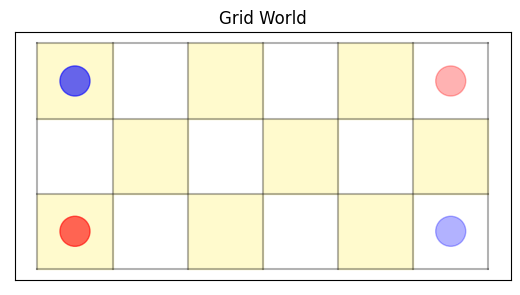

In [2]:
# define grid world dimensions n x m
n = 6
m = 3

# initialize robots        
r1 = Robot('A', (0,0), (5,2))
r2 = Robot('B', (0,2), (5,0))
robots = [r1,r2]

plot_grid_world(n,m,robots)

### Define dynamics contracts for each robot per timestep

We will break up the execution into individual timesteps as our planning horizon to reduce the complexity of the planning problem. This horizon length can be increased depending on the problem to be solved, but for the purpose if this case study we will do our planning in increments of single time steps.

Now we define the contracts for the robots' dynamics, the input variables are the current position of each robot $(x,y)$ and the current timestep. The output variables are the next position of the robots $(x,y)$ and the next timestep. 

In the assumptions we define the initial positions and time step as:
$$t_0 \leq t \quad \text{and} \quad t_0 \geq t$$
$$x_0 \leq x_{init} \quad \text{and} \quad x_0 \geq x_{init}$$
$$y_0 \leq y_{init} \quad \text{and} \quad y_0 \geq y_{init}$$

The guarantees of the contract are defining the dynamics and ensure that the time step increases by 1.
$$t_1 - t_0 \leq 1 \quad \text{and} \quad t_1 - t_0 \geq 1$$

The dynamics allow any single cell N-S or E-W transition on the grid and are specified as:
$$x_0 - x_1 + y_1 - y_2 \leq 1$$
$$x_0 - x_1 - y_1 + y_2 \leq 1$$
$$-x_0 + x_1 + y_1 - y_2 \leq 1$$
$$-x_0 + x_1 - y_1 + y_2 \leq 1$$

We also ensure that the robot has to remain within the grid, specified as:
$$x_1 \leq n-1$$
$$y_1 \leq m-1$$

Note that we need one dynamics contract for each robot, as the contract can only describe the dynamics for the robot whose behavior it describes. We are extending the input and output variables to include the variables for the other robots and the other contracts that we will use later, but each robot's dynamics contract only specifies the guarantees for its respecive robot's coordinates for the next timestep.

In [3]:
def get_dynamics_contract_robot(name, other_in_strs, other_out_strs, init_pos, goal, timestep): # get dynamics contract for robot 'name'
    distance_to_goal = np.abs(init_pos.x-goal.x)+np.abs(init_pos.y-goal.y)
    X_str_0 = 'x_'+str(name)+'_0'
    Y_str_0 = 'y_'+str(name)+'_0'
    X_str_1 = 'x_'+str(name)+'_1'
    Y_str_1 = 'y_'+str(name)+'_1'

    contract = {
    "InputVars": [X_str_0, Y_str_0, "t_0"] + other_in_strs,
    "OutputVars": [X_str_1, Y_str_1, "t_1"] + other_out_strs,
        
    "assumptions": [
    # Initial position
    {"constant": init_pos.x, "coefficients": {X_str_0: 1}},
    {"constant": -init_pos.x, "coefficients": {X_str_0: -1}},
    {"constant": init_pos.y, "coefficients": {Y_str_0: 1}},
    {"constant": -init_pos.y, "coefficients": {Y_str_0: -1}},
    # set timestep
    {"constant": -timestep, "coefficients": {"t_0": -1}},
    {"constant": timestep, "coefficients": {"t_0": 1}}
    ],
        
    "guarantees": [
      # increment timestep by 1
      {"constant": 1, "coefficients": {"t_1": 1, "t_0": -1}},
      {"constant": -1, "coefficients": {"t_1": -1, "t_0": 1}},
      # dynamics
      {"constant": 1, "coefficients": {X_str_1: 1, X_str_0: -1, Y_str_1: 1, Y_str_0: -1}}, 
      {"constant": 1, "coefficients": {X_str_1: 1, X_str_0: -1, Y_str_1: -1, Y_str_0: 1}},
      {"constant": 1, "coefficients": {X_str_1: -1, X_str_0: 1, Y_str_1: 1, Y_str_0: -1}},
      {"constant": 1, "coefficients": {X_str_1: -1, X_str_0: 1, Y_str_1: -1, Y_str_0: 1}},
      # remain in grid
      {"constant": n-1, "coefficients": {X_str_1: 1}},
      {"constant": 0, "coefficients": {X_str_1: -1}},
      {"constant": m-1, "coefficients": {Y_str_1: 1}},
      {"constant": 0, "coefficients": {Y_str_1: -1}},
      ]
    }
    return contract

### Methodological implementation of OR by viewpoints
Next we describe the contracts that will ensure that our robots do not collide. For this we will place constraints on the distance between a pair of robots, and ensure that is will always be larger or equal to one cell - meaning two robots will never share the same cell (i.e. collide).

To describe the this requirement in linear inequalities, we need to break up the contract into four smaller contracts. Each contract will place constraints on both robots for a specific configuration with regards to each other (for example robot A is to the top right of robot B). We will refer to these configurations as 'collision quadrants'.

As the guarantees of these contracts are mutually exclusive (robots can only be in one configuration at a time - Robot A cannot be to the right and to the left of robot B at the same time), we need to consider each of these collision quadrants separately in our analysis. This is our methodological implementation of the 'OR' operator of a requirement.

The collision quadrant contracts for two robots $A$ and $B$ are defined as follows.

We assume that the two robots do not collide:
$$distance(A,B) \geq 1$$

Each collision quadrant enforces one of these guarantees:

$$ x^A_1 - x^B_1 + y^A_1 - y^B_1 \leq -1 $$
$$ x^A_1 - x^B_1 - y^A_1 + y^B_1 \leq -1 $$
$$ x^A_1 + x^B_1 + y^A_1 - y^B_1 \leq -1 $$
$$ x^A_1 + x^B_1 - y^A_1 + y^B_1 \leq -1 $$

We will show the first collision contract and import the remaining contracts from utils.

In [4]:
def collision_quadrant_1():
    
    contract = {
    "InputVars": ["x_A_0", "y_A_0","x_B_0", "y_B_0", "t_0", "current_distance"],
    "OutputVars": ["x_A_1", "y_A_1", "x_B_1", "y_B_1", "t_1"],
    "assumptions": [
    # Assume no collision
    {"constant": -1, "coefficients": {"current_distance": -1}}
    ],
    "guarantees": [
      # collision quadrant constraints (for each set of robots)
      {"constant": -1, "coefficients": {"x_A_1": 1, "x_B_1": -1, "y_A_1": 1, "y_B_1": -1}}
     ]

    }
    return contract

from utils.contract_utils import collision_quadrant_2, collision_quadrant_3, collision_quadrant_4

Now we use pacti to read in the contracts from the functions and display them to confirm we set them up as desired.

In [5]:
contract_dyn1 = get_dynamics_contract_robot(r1.name, ['x_B_0', 'y_B_0', "current_distance"], ['x_B_1', 'y_B_1'], r1.pos, r1.goal, 0)
contract_dyn2 = get_dynamics_contract_robot(r2.name, ['x_A_0', 'y_A_0', "current_distance"], ['x_A_1', 'y_A_1'], r2.pos, r2.goal, 0)
contract_collision_q1 = collision_quadrant_1()
contract_collision_q2 = collision_quadrant_2()
contract_collision_q3 = collision_quadrant_3()
contract_collision_q4 = collision_quadrant_4()

c_dyn1 = read_contract(contract_dyn1)
c_dyn2 = read_contract(contract_dyn2)
c_q1 = read_contract(contract_collision_q1)
c_q2 = read_contract(contract_collision_q2)
c_q3 = read_contract(contract_collision_q3)
c_q4 = read_contract(contract_collision_q4)


print("Contract A:\n" + str(c_dyn1))
print("Contract B:\n" + str(c_dyn2))

print("Collision Quadrant Q1:\n" + str(c_q1))

Contract A:
InVars: [<Var x_A_0>, <Var y_A_0>, <Var t_0>, <Var x_B_0>, <Var y_B_0>, <Var current_distance>]
OutVars:[<Var x_A_1>, <Var y_A_1>, <Var t_1>, <Var x_B_1>, <Var y_B_1>]
A: 1*x_A_0 <= 0.0, -1*x_A_0 <= 0.0, 1*y_A_0 <= 0.0, -1*y_A_0 <= 0.0, -1*t_0 <= 0.0, 1*t_0 <= 0.0
G: -1*t_0 + 1*t_1 <= 1.0, 1*t_0 + -1*t_1 <= -1.0, -1*x_A_0 + 1*x_A_1 + -1*y_A_0 + 1*y_A_1 <= 1.0, -1*x_A_1 <= 0.0, -1*y_A_1 <= 0.0
Contract B:
InVars: [<Var x_B_0>, <Var y_B_0>, <Var t_0>, <Var x_A_0>, <Var y_A_0>, <Var current_distance>]
OutVars:[<Var x_B_1>, <Var y_B_1>, <Var t_1>, <Var x_A_1>, <Var y_A_1>]
A: 1*x_B_0 <= 0.0, -1*x_B_0 <= 0.0, 1*y_B_0 <= 2.0, -1*y_B_0 <= -2.0, -1*t_0 <= 0.0, 1*t_0 <= 0.0
G: -1*t_0 + 1*t_1 <= 1.0, 1*t_0 + -1*t_1 <= -1.0, -1*x_B_0 + 1*x_B_1 + 1*y_B_0 + -1*y_B_1 <= 1.0, -1*x_B_1 <= 0.0, 1*y_B_1 <= 2.0
Collision Quadrant Q1:
InVars: [<Var x_A_0>, <Var y_A_0>, <Var x_B_0>, <Var y_B_0>, <Var t_0>, <Var current_distance>]
OutVars:[<Var x_A_1>, <Var y_A_1>, <Var x_B_1>, <Var y_B_1>, <Var

### Methodologial implementation of OR by transforming variables
Next we define the contract that determines that the robots will also stay collision free during their transition to another cell, meaning that two robots cannot switch places in the grid, as they would collide. We do this by manipulating the $x$ and $y$ coordinates of the two robots as follows:

 $$    \delta x = (x^A_0 - x^B_0) * (x^A_1 - x^B_1) $$
 $$    \delta y = (y^A_0 - y^B_0) * (y^A_1 - y^B_1) $$
 
 $$\delta x + \delta y \geq 1$$
 
Of course this contract also assumes no collision.
 
This is the second methodological way to encode an OR in the contract.

In [6]:
def dynamic_collision_constraints(): # transforming the variables such that we only need two inequalities
    
    contract = {
    "InputVars": ["delta_x", "delta_y", "current_distance"],
    "OutputVars": [" "],
    "assumptions": [
    # Assume no collision
    {"constant": -1, "coefficients": {"current_distance": -1}}
    ],
     "guarantees": [
     # dynamic collision constraints (for each set of robots)
     # delta_x + delta_y >= 1
     {"constant": -1, "coefficients": {"delta_x": -1, "delta_y": -1}}
    ]
    }
    return contract

contract_dynamic_collision = dynamic_collision_constraints()
c_dyn_collision = read_contract(contract_dynamic_collision)


print("Dynamic Collision Contract:\n" + str(c_dyn_collision))

Dynamic Collision Contract:
InVars: [<Var delta_x>, <Var delta_y>, <Var current_distance>]
OutVars:[<Var  >]
A: -1*current_distance <= -1.0
G: -1*delta_x + -1*delta_y <= -1.0


### Merging the contracts
Now we are ready to start merging the contracts. We start by merging the dynamics contracts for each of the robots. This contract now holds all the information for possible steps that both robots can take, but it does not ensure no collisions yet.

In [7]:
merged_dyn_contract = c_dyn1.merge(c_dyn2)

To ensure that our robots will remain collision-free during the run, we now need to check the solutions that satisfy each of the collision quadrants. We merge each collision quadrant contract with the dynamics contract separately for our analysis. Not all of them will be satisfiable depending on the location of the robots on the grid, we will only consider the satisfiable contracts.

In [8]:
# return list of all satisfyable contracts
def check_collision_quadrants(merged_dyn_contract, c_q1, c_q2, c_q3, c_q4):
    merged_contracts = []

    try:
        merged_contract_q1 = merged_dyn_contract.merge(c_q1)
        merged_contracts.append(merged_contract_q1)
    except:
        pass

    try:
        merged_contract_q2 = merged_dyn_contract.merge(c_q2)
        merged_contracts.append(merged_contract_q2)
    except:
        pass

    try:
        merged_contract_q3 = merged_dyn_contract.merge(c_q3)
        merged_contracts.append(merged_contract_q3)
    except:
        pass

    try:
        merged_contract_q4 = merged_dyn_contract.merge(c_q4)
        merged_contracts.append(merged_contract_q4)
    except:
        pass
    return merged_contracts


merged_contracts = check_collision_quadrants(merged_dyn_contract, c_q1, c_q2, c_q3, c_q4)

Now we evaluate each of the merged contracts to find all possible moves that the robots can take which will satisfy our specification. From this list we can implement any desired strategy that will lead the robots to their goal.

In [9]:
def find_move_candidates(r1, r2, t_0, contract, c_dyn_collision):
    
    x_A_0 = r1.pos.x
    y_A_0 = r1.pos.y
    x_B_0 = r2.pos.x 
    y_B_0 = r2.pos.y
    current_distance = np.abs(x_A_0-x_B_0)+np.abs(x_A_0-x_B_0)

    t_1 = t_0 + 1
    # find possible [(x,y),(x,y)] options for robots
    possible_sol = []
    for x_a in range(n):
        for y_a in range(m):
            for x_b in range(n):
                for y_b in range(m):
                    x_A_1 = x_a
                    y_A_1 = y_a
                    x_B_1 = x_b
                    y_B_1 = y_b
                    
                    delta_x = (x_a - x_b)*(x_A_0 - x_B_0)
                    delta_y = (y_a - y_b)*(y_A_0 - y_B_0)

                    sol = True
                    for g in contract.g.terms:
                        holds = eval(str(g))
                        dynamic_collision_holds = eval(str(c_dyn_collision.g))
                        if not holds or not dynamic_collision_holds:
                            sol = False

                    if sol:
                        possible_sol.append([(x_a,y_a),(x_b,y_b)])
    return possible_sol, t_1

t_0 = 0
sols = []
for i in range(len(merged_contracts)):
    possible_sol, t_1 = find_move_candidates(r1, r2, t_0, merged_contracts[i], c_dyn_collision)
    sols = sols + possible_sol

move_candidates = []
for sol in sols:
    if sol not in move_candidates:
        move_candidates.append(sol)
 
# now pick a move and run it again for the next timestep!
move = strategy(move_candidates,(r1.goal,r2.goal))
print('These are the possible positions for the next timestep: ' + str(move_candidates))

print('The chosen move is '+str(move))

These are the possible positions for the next timestep: [[(0, 0), (0, 1)], [(0, 0), (0, 2)], [(0, 0), (1, 2)], [(0, 1), (0, 2)], [(0, 1), (1, 2)], [(1, 0), (0, 2)], [(1, 0), (1, 2)], [(1, 0), (0, 1)]]
The chosen move is [(1, 0), (1, 2)]


Now we can put everything together and run the simulation of our two robots navigating the grid together.

In [10]:
r1 = Robot('A', (0,0), (5,2))
r2 = Robot('B', (0,2), (5,0))
trace = []
robots = [r1,r2]

t = 0
trace = save_trace(trace, [(r1.pos.x, r1.pos.y),(r2.pos.x, r2.pos.y)], [(r1.goal.x, r1.goal.y),(r2.goal.x, r2.goal.y)])

for i in range(0,10):
    contract_dyn1 = get_dynamics_contract_robot(r1.name, ['x_B_0', 'y_B_0', 'current_distance'], ['x_B_1', 'y_B_1'], r1.pos, r1.goal, t)
    contract_dyn2 = get_dynamics_contract_robot(r2.name, ['x_A_0', 'y_A_0', 'current_distance'], ['x_A_1', 'y_A_1'], r2.pos, r2.goal, t)
    c_dyn1 = read_contract(contract_dyn1)
    c_dyn2 = read_contract(contract_dyn2)
    merged_dyn_contract = c_dyn1.merge(c_dyn2)
    merged_contracts = check_collision_quadrants(merged_dyn_contract, c_q1, c_q2, c_q3, c_q4)
    
    sols = []
    for i in range(len(merged_contracts)):
        possible_sol, t_1 = find_move_candidates(r1, r2, t_0, merged_contracts[i], c_dyn_collision)
        sols = sols + possible_sol

    move_candidates = []
    for sol in sols:
        if sol not in move_candidates:
            move_candidates.append(sol)
    move = strategy(move_candidates,(r1.goal,r2.goal))
    r1.move(move[0])
    r2.move(move[1])
    
    trace = save_trace(trace, [(r1.pos.x, r1.pos.y),(r2.pos.x, r2.pos.y)], [(r1.goal.x, r1.goal.y),(r2.goal.x, r2.goal.y)])
    
    if distance([[r1.pos.x, r1.pos.y],[r2.pos.x, r2.pos.y]],[r1.goal,r2.goal]) == 0:
        break;
        
animate(trace, n, m, '2_robots')

Rendering 8 frames...


This is how to set up a multi-agent navigation problem in pacti with a horizon of a single timestep, if desired this horizon can be extended by composing multiple timesteps to ensure that the robots will not get stuck depending on the obstacle placement and the actions that the robots are taking. For this case study we will continue using a horizon length of one but we will increase the number of robots in our grid world.

### Extension to three robots

In [12]:
# set grid world dimensions n x m
n = 6
m = 3

# Intitialize the robots
r1 = Robot('A', (0,0), (5,2))
r2 = Robot('B', (0,2), (5,0))
r3 = Robot('C', (0,1), (5,1))
robots = [r1,r2,r3]

# Get the collision contracts
collision_AB = get_collision_contracts_robot_pair('A', 'B', 'C')
collision_AC = get_collision_contracts_robot_pair('A', 'C', 'B')
collision_BC = get_collision_contracts_robot_pair('B', 'C', 'A')
collision_contracts = [collision_AB, collision_AC, collision_BC]
c_dyn_collision = get_dynamic_collision_contract(robots)

t = 0
trace = []
trace = save_trace(trace, [(r1.pos.x, r1.pos.y),(r2.pos.x, r2.pos.y),(r3.pos.x, r3.pos.y)], [(r1.goal.x, r1.goal.y),(r2.goal.x, r2.goal.y),(r3.goal.x, r3.goal.y)])

for i in range(0,15):
    contract_dyn1 = get_dynamics_contract_robot(r1.name, ['x_B_0','y_B_0','x_C_0','y_C_0', 'current_distance'],['x_B_1','y_B_1','x_C_1','y_C_1'], r1.pos, r1.goal, t)
    contract_dyn2 = get_dynamics_contract_robot(r2.name, ['x_A_0','y_A_0','x_C_0','y_C_0', 'current_distance'],['x_A_1','y_A_1','x_C_1','y_C_1'], r2.pos, r2.goal, t)
    contract_dyn3 = get_dynamics_contract_robot(r3.name, ['x_A_0','y_A_0','x_B_0','y_B_0', 'current_distance'],['x_A_1','y_A_1','x_B_1','y_B_1'], r3.pos, r3.goal, t)
    c_dyn1 = read_contract(contract_dyn1)
    c_dyn2 = read_contract(contract_dyn2)
    c_dyn3 = read_contract(contract_dyn3)
    
    merged_dyn_contract_1_2 = c_dyn1.merge(c_dyn2)
    merged_dyn_contract = merged_dyn_contract_1_2.merge(c_dyn3)
    
    moves_list = get_possible_moves_multiple_robots(n,m,robots, merged_dyn_contract, collision_contracts, c_dyn_collision)
    
    move = strategy_multiple(moves_list,(r1.goal,r2.goal,r3.goal))
    r1.move(move[0])
    r2.move(move[1])
    r3.move(move[2])
    
    trace = save_trace(trace, [(r1.pos.x, r1.pos.y),(r2.pos.x, r2.pos.y),(r3.pos.x, r3.pos.y)], [(r1.goal.x, r1.goal.y),(r2.goal.x, r2.goal.y), (r3.goal.x, r3.goal.y)])
    
    if distance([[r1.pos.x, r1.pos.y],[r2.pos.x, r2.pos.y]],[r1.goal,r2.goal, r3.goal]) == 0:
        break;
    t = t + 1
        
animate(trace, n, m, '3_robots')

Rendering 8 frames...


This analysis can be extended to add obstacles (by adding a contract that ensures no collision with obstacles) and add more robots to the grid as desired. We set up our contracts to describe the viewpoint for a single timestep, but depending on the obstacle geometry and the number of robots, it may be necessary to consider a longer horizon. For this we could compose the contracts for multiple timesteps and pick the strategy on the possible action set resulting from this analysis, which we leave to future work.